# Tennis Swing Analysis v2 — Reference Feature Extraction

This notebook extracts biomechanical features from pro player training videos
using MediaPipe Pose Landmarker, producing CSV reference files for the DTW comparison engine.

**Steps:**
1. Mount Google Drive
2. Install dependencies & download MediaPipe model
3. Configure paths to your training videos
4. Extract pose landmarks + biomechanical features
5. Download/save reference CSVs

## 1. Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Install dependencies
!pip install -q tensorflow tensorflow-hub opencv-python-headless numpy pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.2 MB/s eta 0:00:00


In [3]:
# Load MoveNet Thunder from TensorFlow Hub
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']
INPUT_SIZE = 256

print(f"✅ MoveNet Thunder loaded")
print(f"   Input size: {INPUT_SIZE}x{INPUT_SIZE}")
print(f"   GPU available: {tf.config.list_physical_devices('GPU')}")

Downloaded model to /content/pose_landmarker_heavy.task


## 2. Configure Paths

In [4]:
# =====================================================
# EDIT THESE PATHS to match your Google Drive structure
# =====================================================

VIDEOS_DIR = 'drive/My Drive/tennis-swing-analysis-v2/videos_training_v2'
OUTPUT_DIR = 'drive/My Drive/tennis-swing-classification/references_v2'

# Max seconds to process per video (None = full video)
MAX_SECONDS = None

WINDOW_SECONDS = 10   # Each reference segment length (matches user upload)
STRIDE_SECONDS = 5    # Slide step (50% overlap for good coverage)

In [5]:
# List available videos
from pathlib import Path

videos_dir = Path(VIDEOS_DIR)
print(f"Looking for videos in: {videos_dir}\n")

if not videos_dir.exists():
    print("ERROR: Directory not found! Check VIDEOS_DIR path above.")
else:
    for player_dir in sorted(videos_dir.iterdir()):
        if player_dir.is_dir():
            videos = list(player_dir.glob('*.mp4')) + list(player_dir.glob('*.MP4'))
            print(f"{player_dir.name}: {len(videos)} videos")
            for v in sorted(videos):
                print(f"  - {v.name}")
    print()

Looking for videos in: drive/My Drive/tennis-swing-analysis-v2/videos_training_v2

Djokovic: 10 videos
  - Djokovic1_v3.mp4
  - Djokovic21_v3.mp4
  - Djokovic22_v3.mp4
  - Djokovic2_v3.mp4
  - Djokovic3_v3.mp4
  - Djokovic4_v3.mp4
  - Djokovic5_v3.mp4
  - Djokovic6_v3.mp4
  - Djokovic7_v3.mp4
  - Djokovic8_v3.mp4
Federer: 5 videos
  - Federer1_v3.mp4
  - Federer2_v3.mp4
  - Federer3_v3.mp4
  - Federer4_v3.mp4
  - Federer5_v3.mp4
Murray: 8 videos
  - Murray1_v3.mp4
  - Murray2_v3.mp4
  - Murray3_v3.mp4
  - Murray4_v3.mp4
  - Murray5_v3.mp4
  - Murray6_v3.mp4
  - Murray7_v3.mp4
  - Murray8_v3.mp4
Nadal: 5 videos
  - Nadal1_v3.mp4
  - Nadal2_v3.mp4
  - Nadal3_v3.mp4
  - Nadal4_v3.mp4
  - Nadal5_v3.mp4



## 3. Biomechanical Feature Extraction Functions

In [6]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter


# MoveNet keypoint indices (17 keypoints)
# 0: nose, 1: left_eye, 2: right_eye, 3: left_ear, 4: right_ear
# 5: left_shoulder, 6: right_shoulder, 7: left_elbow, 8: right_elbow
# 9: left_wrist, 10: right_wrist, 11: left_hip, 12: right_hip
# 13: left_knee, 14: right_knee, 15: left_ankle, 16: right_ankle

L_SHOULDER, R_SHOULDER = 5, 6
L_ELBOW, R_ELBOW = 7, 8
L_WRIST, R_WRIST = 9, 10
L_HIP, R_HIP = 11, 12
L_KNEE, R_KNEE = 13, 14
L_ANKLE, R_ANKLE = 15, 16


def compute_angle(a: np.ndarray, b: np.ndarray, c: np.ndarray) -> float:
    """Compute angle (degrees) at point b, formed by points a-b-c."""
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    return float(np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0))))


def extract_frame_features(keypoints: np.ndarray) -> dict:
    """
    Extract biomechanical features from one frame of MoveNet keypoints.

    Args:
        keypoints: numpy array of shape (17, 3) — [y, x, confidence] per keypoint
    """
    # MoveNet outputs [y, x, confidence] — convert to [x, y] for consistency
    pts = np.zeros((17, 2))
    pts[:, 0] = keypoints[:, 1]  # x
    pts[:, 1] = keypoints[:, 0]  # y

    f = {}

    # Joint angles
    f['r_elbow_angle'] = compute_angle(pts[R_SHOULDER], pts[R_ELBOW], pts[R_WRIST])
    f['l_elbow_angle'] = compute_angle(pts[L_SHOULDER], pts[L_ELBOW], pts[L_WRIST])
    f['r_shoulder_angle'] = compute_angle(pts[R_HIP], pts[R_SHOULDER], pts[R_ELBOW])
    f['l_shoulder_angle'] = compute_angle(pts[L_HIP], pts[L_SHOULDER], pts[L_ELBOW])
    f['r_knee_angle'] = compute_angle(pts[R_HIP], pts[R_KNEE], pts[R_ANKLE])
    f['l_knee_angle'] = compute_angle(pts[L_HIP], pts[L_KNEE], pts[L_ANKLE])
    f['r_hip_angle'] = compute_angle(pts[R_SHOULDER], pts[R_HIP], pts[R_KNEE])
    f['l_hip_angle'] = compute_angle(pts[L_SHOULDER], pts[L_HIP], pts[L_KNEE])

    # Torso rotation
    shoulder_vec = pts[R_SHOULDER] - pts[L_SHOULDER]
    hip_vec = pts[R_HIP] - pts[L_HIP]
    f['torso_rotation'] = float(np.degrees(
        np.arctan2(shoulder_vec[1], shoulder_vec[0]) -
        np.arctan2(hip_vec[1], hip_vec[0])
    ))

    # Distances
    f['stance_width'] = float(np.linalg.norm(pts[R_ANKLE] - pts[L_ANKLE]))
    f['shoulder_width'] = float(np.linalg.norm(pts[R_SHOULDER] - pts[L_SHOULDER]))
    f['r_wrist_height'] = float(pts[R_SHOULDER][1] - pts[R_WRIST][1])
    f['l_wrist_height'] = float(pts[L_SHOULDER][1] - pts[L_WRIST][1])
    f['wrist_separation'] = float(np.linalg.norm(pts[R_WRIST] - pts[L_WRIST]))

    # Body center & balance
    hip_center = (pts[L_HIP] + pts[R_HIP]) / 2
    shoulder_center = (pts[L_SHOULDER] + pts[R_SHOULDER]) / 2
    f['body_lean'] = float(shoulder_center[0] - hip_center[0])
    f['forward_lean'] = float(shoulder_center[1] - hip_center[1])

    # Arm extension
    f['r_arm_extension'] = float(np.linalg.norm(pts[R_WRIST] - pts[R_SHOULDER]))
    f['l_arm_extension'] = float(np.linalg.norm(pts[L_WRIST] - pts[L_SHOULDER]))

    return f


def extract_sequence_features(keypoints_sequence: list) -> pd.DataFrame:
    """Extract features from all frames, with smoothing."""
    frames = []
    for kp in keypoints_sequence:
        if kp is not None:
            frames.append(extract_frame_features(kp))

    df = pd.DataFrame(frames)

    # Smooth
    for col in df.columns:
        if len(df[col].dropna()) > 11:
            try:
                df[col] = savgol_filter(df[col].values, window_length=11, polyorder=3)
            except Exception:
                pass

    return df


sample_features = list(extract_frame_features(np.random.rand(17, 3)).keys())
print(f"Feature extraction loaded. {len(sample_features)} features:")
print(sample_features)

Feature extraction functions loaded.
Features per frame: 8
Features (18): ['r_elbow_angle', 'l_elbow_angle', 'r_shoulder_angle', 'l_shoulder_angle', 'r_knee_angle', 'l_knee_angle', 'r_hip_angle', 'l_hip_angle', 'torso_rotation', 'stance_width', 'shoulder_width', 'r_wrist_height', 'l_wrist_height', 'wrist_separation', 'body_lean', 'forward_lean', 'r_arm_extension', 'l_arm_extension']


## 4. Pose Detection Functions

In [8]:
import cv2

def extract_keypoints_from_video(video_path: str, max_seconds: float = None):
    """
    Run MoveNet Thunder on a video, return (keypoints_sequence, fps).

    Each element in keypoints_sequence is a (17, 3) numpy array [y, x, confidence]
    or None if detection failed.
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    max_frames = int(fps * max_seconds) if max_seconds else total_frames

    keypoints_sequence = []
    frame_idx = 0

    while cap.isOpened() and frame_idx < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize and prepare for MoveNet
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = tf.image.resize_with_pad(tf.expand_dims(rgb, axis=0), INPUT_SIZE, INPUT_SIZE)
        img = tf.cast(img, dtype=tf.int32)

        # Run inference
        outputs = movenet(img)
        keypoints = outputs['output_0'].numpy()[0, 0, :, :]  # (17, 3)

        # Check if enough keypoints were detected with confidence
        confidence = keypoints[:, 2]
        if np.mean(confidence) > 0.1:
            keypoints_sequence.append(keypoints)
        else:
            keypoints_sequence.append(None)

        frame_idx += 1

    cap.release()
    return keypoints_sequence, fps


print("Pose detection loaded (MoveNet Thunder + TF GPU)")

NameError: name 'BaseOptions' is not defined

## 5. Run Extraction

In [ ]:
import time

output_dir = Path(OUTPUT_DIR)
total_processed = 0
total_segments = 0
total_skipped = 0
results_summary = []

for player_dir in sorted(videos_dir.iterdir()):
    if not player_dir.is_dir():
        continue

    player_name = player_dir.name
    video_files = sorted(list(player_dir.glob('*.mp4')) + list(player_dir.glob('*.MP4')))

    if not video_files:
        continue

    sep = '=' * 60
    print(f"\n{sep}")
    print(f"Player: {player_name} ({len(video_files)} videos)")
    print(sep)

    for video_file in video_files:
        start_time = time.time()
        print(f"\n  📹 {video_file.name}")

        # Extract keypoints from full video
        print("     Pose detection...", end=' ', flush=True)
        keypoints_seq, fps = extract_keypoints_from_video(
            str(video_file), MAX_SECONDS
        )

        valid = sum(1 for kp in keypoints_seq if kp is not None)
        total = len(keypoints_seq)
        ratio = valid / total if total > 0 else 0
        duration = total / fps if fps > 0 else 0
        print(f"{total} frames ({duration:.1f}s), {valid} with pose ({ratio*100:.0f}%)")

        if ratio < 0.5:
            print("     ⚠️  Skipping — too few valid frames")
            total_skipped += 1
            continue

        # Extract features from full video
        print("     Extracting features...", end=' ', flush=True)
        all_frames_features = []
        for kp in keypoints_seq:
            if kp is not None:
                all_frames_features.append(extract_frame_features(kp))
        full_df = pd.DataFrame(all_frames_features)

        # Smooth the full sequence
        for col in full_df.columns:
            if len(full_df[col].dropna()) > 11:
                try:
                    full_df[col] = savgol_filter(full_df[col].values, window_length=11, polyorder=3)
                except Exception:
                    pass

        print(f"{len(full_df)} frames x {len(full_df.columns)} features")

        # Slice into windows
        window_frames = int(WINDOW_SECONDS * fps)
        stride_frames = int(STRIDE_SECONDS * fps)
        num_segments = 0

        for win_start in range(0, len(full_df) - window_frames + 1, stride_frames):
            win_end = win_start + window_frames
            segment_df = full_df.iloc[win_start:win_end].reset_index(drop=True)

            seg_name = f"{video_file.stem}_seg{num_segments:03d}"
            save_path = output_dir / player_name / f"{seg_name}.csv"
            save_path.parent.mkdir(parents=True, exist_ok=True)
            segment_df.to_csv(save_path, index=False)
            num_segments += 1

        elapsed = time.time() - start_time
        print(f"     ✅ {num_segments} segments saved ({elapsed:.1f}s)")

        total_processed += 1
        total_segments += num_segments
        results_summary.append({
            'player': player_name,
            'video': video_file.name,
            'duration_s': round(duration, 1),
            'frames': total,
            'segments': num_segments,
            'time_s': round(elapsed, 1),
        })

sep = '=' * 60
print(f"\n\n{sep}")
print(f"DONE! Videos: {total_processed} | Segments: {total_segments} | Skipped: {total_skipped}")
print(f"Output: {output_dir}")

## 6. Verify Results

In [ ]:
# Summary table
import pandas as pd

if results_summary:
    df_summary = pd.DataFrame(results_summary)
    print("Extraction Summary:")
    print(df_summary.to_string(index=False))
    print(f"\nTotal processing time: {df_summary['time_s'].sum():.0f}s")
    print(f"Total segments: {df_summary['segments'].sum()}")
    print("\nPer player:")
    per_player = df_summary.groupby('player').agg(
        videos=('video', 'count'),
        segments=('segments', 'sum'),
        total_duration=('duration_s', 'sum')
    )
    print(per_player.to_string())

Extraction Summary:
  player             video  frames  valid_frames  features  time_s
Djokovic  Djokovic1_v3.mp4    1046          1040        18    71.6
Djokovic Djokovic21_v3.mp4    3941          3937        18   276.0
Djokovic Djokovic22_v3.mp4    3420          2906        18   218.8

Total time: 566s

Per player:
player
Djokovic    3


Sample: drive/My Drive/tennis-swing-classification/references_v2/Djokovic/Djokovic1_v3.csv
Shape: (1040, 18)
Columns: ['r_elbow_angle', 'l_elbow_angle', 'r_shoulder_angle', 'l_shoulder_angle', 'r_knee_angle', 'l_knee_angle', 'r_hip_angle', 'l_hip_angle', 'torso_rotation', 'stance_width', 'shoulder_width', 'r_wrist_height', 'l_wrist_height', 'wrist_separation', 'body_lean', 'forward_lean', 'r_arm_extension', 'l_arm_extension']


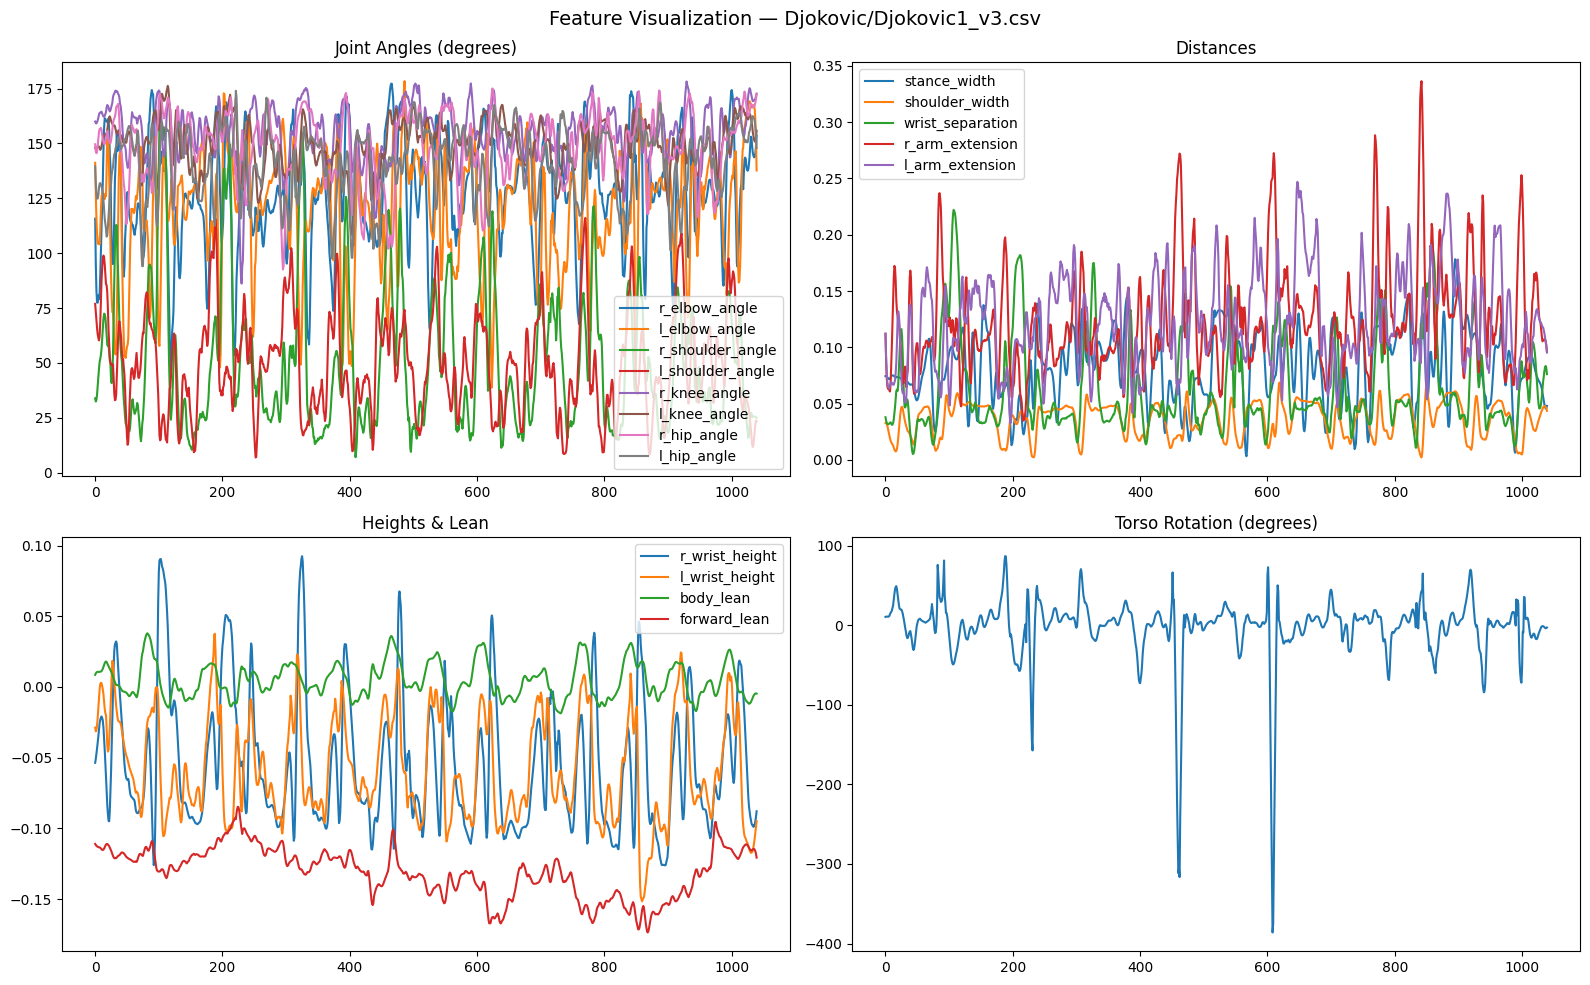

In [ ]:
# Quick sanity check — plot one reference's features
import matplotlib.pyplot as plt

output_dir = Path(OUTPUT_DIR)
csv_files = list(output_dir.rglob('*.csv'))

if csv_files:
    sample_csv = csv_files[0]
    df = pd.read_csv(sample_csv)

    print(f"Sample: {sample_csv}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Feature Visualization — {sample_csv.parent.name}/{sample_csv.name}", fontsize=14)

    # Joint angles
    angle_cols = [c for c in df.columns if 'angle' in c]
    df[angle_cols].plot(ax=axes[0, 0], title='Joint Angles (degrees)')

    # Distances
    dist_cols = ['stance_width', 'shoulder_width', 'wrist_separation', 'r_arm_extension', 'l_arm_extension']
    df[[c for c in dist_cols if c in df.columns]].plot(ax=axes[0, 1], title='Distances')

    # Heights & lean
    height_cols = ['r_wrist_height', 'l_wrist_height', 'body_lean', 'forward_lean']
    df[[c for c in height_cols if c in df.columns]].plot(ax=axes[1, 0], title='Heights & Lean')

    # Torso rotation
    if 'torso_rotation' in df.columns:
        df['torso_rotation'].plot(ax=axes[1, 1], title='Torso Rotation (degrees)')

    plt.tight_layout()
    plt.show()
else:
    print("No CSV files found. Check OUTPUT_DIR.")

## 6b. Visual Check — Pose Overlay on Video

In [ ]:
# =====================================================
# Pick a video to visualize (edit these)
# =====================================================
VIZ_PLAYER = "Djokovic"
VIZ_VIDEO = "Djokovic1_v3.mp4"
VIZ_START_SEC = 0
VIZ_DURATION_SEC = 10

# =====================================================

import cv2
from IPython.display import HTML
import tempfile
import base64

viz_video_path = str(Path(VIDEOS_DIR) / VIZ_PLAYER / VIZ_VIDEO)
print(f"Video: {viz_video_path}")

# MoveNet skeleton connections for drawing
EDGES = [
    (0, 1), (0, 2), (1, 3), (2, 4),       # Head
    (5, 6),                                  # Shoulders
    (5, 7), (7, 9),                          # Left arm
    (6, 8), (8, 10),                         # Right arm
    (5, 11), (6, 12),                        # Torso
    (11, 12),                                # Hips
    (11, 13), (13, 15),                      # Left leg
    (12, 14), (14, 16),                      # Right leg
]

cap = cv2.VideoCapture(viz_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

start_frame = int(VIZ_START_SEC * fps)
max_frames = int(VIZ_DURATION_SEC * fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

output_frames = []
for i in range(max_frames):
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = tf.image.resize_with_pad(tf.expand_dims(rgb, axis=0), INPUT_SIZE, INPUT_SIZE)
    img = tf.cast(img, dtype=tf.int32)

    outputs = movenet(img)
    keypoints = outputs['output_0'].numpy()[0, 0, :, :]  # (17, 3)

    annotated = frame.copy()

    # Draw skeleton
    for edge in EDGES:
        p1_idx, p2_idx = edge
        y1, x1, c1 = keypoints[p1_idx]
        y2, x2, c2 = keypoints[p2_idx]
        if c1 > 0.2 and c2 > 0.2:
            pt1 = (int(x1 * width), int(y1 * height))
            pt2 = (int(x2 * width), int(y2 * height))
            cv2.line(annotated, pt1, pt2, (0, 255, 128), 2)

    # Draw keypoints
    for idx in range(17):
        y, x, conf = keypoints[idx]
        if conf > 0.2:
            cx, cy = int(x * width), int(y * height)
            color = (0, 255, 255) if idx in [5,6,7,8,9,10,11,12,13,14,15,16] else (200, 200, 200)
            cv2.circle(annotated, (cx, cy), 4, color, -1)

    output_frames.append(annotated)

cap.release()
print(f"Processed {len(output_frames)} frames ({len(output_frames)/fps:.1f}s)")

# Encode and display
tmp = tempfile.NamedTemporaryFile(suffix='.mp4', delete=False)
out = cv2.VideoWriter(tmp.name, cv2.VideoWriter_fourcc(*'avc1'), fps, (width, height))
for f in output_frames:
    out.write(f)
out.release()

with open(tmp.name, 'rb') as vf:
    b64 = base64.b64encode(vf.read()).decode()
html = f"""
<p><b>{VIZ_PLAYER} — {VIZ_VIDEO}</b> ({len(output_frames)/fps:.1f}s)</p>
<video width="640" controls loop autoplay muted>
  <source src="data:video/mp4;base64,{b64}" type="video/mp4">
</video>
"""
display(HTML(html))
print("\n✅ Video with MoveNet skeleton overlay displayed above.")

ImportError: cannot import name 'solutions' from 'mediapipe' (/usr/local/lib/python3.12/dist-packages/mediapipe/__init__.py)

## 7. Copy to Project
After extraction, copy the  folder into project folder.

In [ ]:
# Optional: zip the references for easy download
import shutil

output_dir = Path(OUTPUT_DIR)
zip_path = output_dir.parent / 'references_v2'
if output_dir.exists():
    shutil.make_archive(str(zip_path), 'zip', str(output_dir))
    print(f"Zipped to: {zip_path}.zip")
    print("Download this file and extract into backend/data/references/")